In [53]:
import numpy as np
import pandas as pd
from sklearn import preprocessing

%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


`%matplotlib` prevents importing * from pylab and numpy


In [54]:
df = pd.read_csv('adult.data')

In [55]:
nominal_columns = set(df.columns)
nominal_columns.remove('age')
nominal_columns.remove('capital-gain')
nominal_columns.remove('hours-per-week')
nominal_columns.remove('capital-loss')
nominal_columns.remove('fnlwgt')
nominal_columns.remove('education-num')
#not a really good idea
#nominal_columns.remove('native-country')
#nominal_columns.remove('education')
#nominal_columns.remove('occupation')

In [56]:
for col_name in nominal_columns:
    print("Column: " + col_name)
    val = df[col_name]
    set_val = set(val)
    set_list = list(set_val)
    #print(len(set_val))
    df[col_name] = map(lambda x : set_list.index(x), df[col_name])

Column: workclass
Column: relationship
Column: label
Column: sex
Column: race
Column: native-country
Column: education
Column: marital-status
Column: occupation


In [57]:
X_train, Y_train = df[df.columns[:-1]].values, df[df.columns[-1]].values

In [58]:
X_train[0]

array([   39,     2, 77516,     8,    13,     5,    10,     5,     1,
           0,  2174,     0,    40,     7])

In [7]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,2,77516,8,13,5,10,5,1,0,2174,0,40,7,0
1,50,5,83311,8,13,6,7,3,1,0,0,0,13,7,0
2,38,0,215646,13,9,1,8,5,1,0,0,0,40,7,0
3,53,0,234721,12,7,6,8,3,4,0,0,0,40,7,0
4,28,0,338409,8,13,6,4,0,4,1,0,0,40,1,0


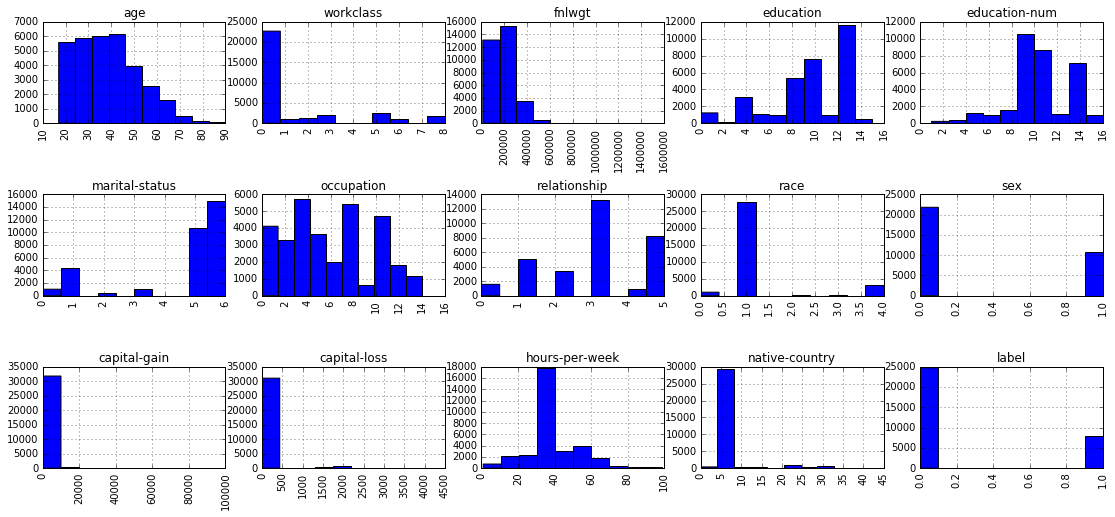

In [8]:
fig = plt.figure(figsize=(19,8))
cols = 5
rows = ceil(float(df.shape[1]) / cols)
for i, column in enumerate(df.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    df[column].hist(axes=ax)
    plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

## Decision tree (CART)
You could use this doc to implement (and hopefully understand) CART: ftp://public.dhe.ibm.com/software/analytics/spss/support/Stats/Docs/Statistics/Algorithms/13.0/TREE-CART.pdf

In [9]:
#здесь и далее l0 - количество элементов класса 0, попадающих в левое поддерево
#l1 - количество элементов класса 1, попадающих в левое поддерево
#r0 - количество элементов класса 0, попадающих в правое поддерево
#r1 - количество элементов класса 1, попадающих в правое поддерево
#L = l0 + l1
#R = r0 + r1

def my_entropy(L, R):
    t = np.array([L * 1.0 / (L + R), R * 1.0 / (L + R)])
    return - np.sum(t * np.log2(t))

def gini(L, R):
    return 1 - (L * 1.0 / (L + R)) ** 2 - (R * 1.0 / (L + R)) ** 2

def twoing(l0, l1, r0, r1):
    L = l0 + l1
    R = r0 + r1
    pl0 = 1.0 * l0 / (l1 + l0)
    pl1 = 1 - pl0
    pr0 = 1.0 * r0 / (r1 + r0)
    pr1 = 1 - pr0
    return L * R * 1.0 / (L + R) ** 2 * ((pl0 - pr0) ** 2 + (pl1 - pr1) ** 2)


In [10]:
class Node:
    def __init__(self, L, R, feature, value, result):
        self.result = None
        self.L = L
        self.R = R
        self.feature = feature
        self.value = value
        self.result = result

In [25]:
import sklearn
class CART(sklearn.base.BaseEstimator, sklearn.base.ClassifierMixin):
    
    def resultNode(self, result):
        return Node(None, None, None, None, result)
    
    def nextVertexNum(self):
        self.vertexCnt += 1
        return self.vertexCnt - 1
    
    def __init__(self, leaf_min_size, tree_depth, criterion):
        self.criterion = criterion
        self.leaf_min_size = leaf_min_size
        self.tree_depth = tree_depth
        self.root = None
        self.vertexCnt = 0
        self.graph_str = 'strict digraph G {\n'
        
    
    def go(self, number, d, X, y):
        #print("go", number, d, X, y)
        total_y_0 = 0
        total_y_1 = 0
        for j in range(len(y)):
            if y[j] == 0:
                total_y_0 += 1
            else:
                total_y_1 += 1
        if self.stopping_criterion(d, X, y):
            #print("stopping criterion")
            chosen_class = 0 if total_y_0 > total_y_1 else 1
            self.graph_str += str(number) + "[label=\"" + "class = " + str(chosen_class) + "\"];\n"
            return self.resultNode(chosen_class)
        max_G = 0
        best_feature = None
        best_value = 0
        for feature in range(len(X[0])):
            cnt_dict = {}
            
            for j in range(len(X)):
                feature_value = X[j][feature]
                (x0, x1) = (0,0) if not feature_value in cnt_dict else cnt_dict[feature_value]
                if y[j] == 0:
                    x0 += 1
                else:
                    x1 += 1
                cnt_dict[feature_value] = (x0, x1)
            l0 = l1 = 0
            r0 = total_y_0
            r1 = total_y_1
            
            for (value, (cnt0, cnt1)) in sorted(cnt_dict.iteritems()):
                l0 += cnt0
                l1 += cnt1
                r0 -= cnt0
                r1 -= cnt1
                if l0 + l1 > 0 and r0 + r1 > 0:
                    #print(gini(l0, l1, r0, r1), twoing(l0, l1, r0, r1))
                    G = self.calc_criterion(l0, l1, r0, r1)
                    #print("G", G)
                    if G > max_G:
                        max_G = G
                        best_value = value
                        best_feature = feature
        assert best_feature != None
        #if best_feature == None:
        #    return self.resultNode(0) if total_y_0 > total_y_1 else self.resultNode(1)
        
        X_left = []
        X_right = []
        y_left = []
        y_right = []
        for j in range(len(X)):
            if X[j][best_feature] <= best_value:
                X_left.append(X[j])
                y_left.append(y[j])
            else:
                X_right.append(X[j])
                y_right.append(y[j])
        assert(len(X_left) > 0)
        assert(len(X_right) > 0)
        
        self.graph_str += str(number) + "[label=\"" + df.columns.values[best_feature] + "<=" + str(best_value) + "\"];\n"
        self.graph_str += str(number) + " -> " + str(self.vertexCnt) + "[label=\"yes\"];\n";
        left_result = self.go(self.nextVertexNum(), d + 1, X_left, y_left)
        self.graph_str += str(number) + " -> " + str(self.vertexCnt) + "[label=\"no\"];\n";
        right_result = self.go(self.nextVertexNum(), d + 1, X_right, y_right)
        
        return Node(left_result, right_result, best_feature, best_value, None)
        
    def calc_criterion(self, l0, l1, r0, r1):
        if self.criterion == 'gini':
            return gini(l0 + l1, r0 + r1)
        elif self.criterion == 'twoing':
            return twoing(l0, l1, r0, r1)
        elif self.criterion == 'entropy':
            return my_entropy(l0 + l1, r0 + r1)
        else:
            raise ValueError("Unknown criterion type!")
        
    def fit(self, X_train, y_train):
        self.root = self.go(self.nextVertexNum(), 0, X_train, y_train)
    
    def stopping_criterion(self, d, X, y):
        if d > self.tree_depth:
            return True
        if max(y) == min(y):
            return True
        if len(X) <= self.leaf_min_size:
            return True
        return False
            
    def predict(self, X_test):
        y_pred = numpy.zeros(X_test.shape[0])
        for j in range(len(X_test)):
            cur_node = self.root
            while cur_node.result == None:
                if X_test[j][cur_node.feature] <= cur_node.value:
                    cur_node = cur_node.L
                else:
                    cur_node = cur_node.R
            y_pred[j] = cur_node.result
        return y_pred

In [12]:
#работает очень быстро, всего за несколько секунд, благодаря оптимизациям в коде fit
from sklearn import cross_validation
cross_validation.cross_val_score(CART(17, 20, 'entropy'), X_train, Y_train)

array([ 0.7345679 ,  0.73530496,  0.7330692 ])

In [13]:
from sklearn import cross_validation
cross_validation.cross_val_score(CART(17, 20, 'twoing'), X_train, Y_train)

array([ 0.82412014,  0.83029298,  0.83285727])

# Visualization

In [14]:
#построим на одних и тех же данных деревья с использование Entropy и Twoing и сравним визуально их структуру
cart_entropy = CART(17, 20, 'entropy')
cart_entropy.fit(X_train[:100], Y_train[:100])


Populating the interactive namespace from numpy and matplotlib


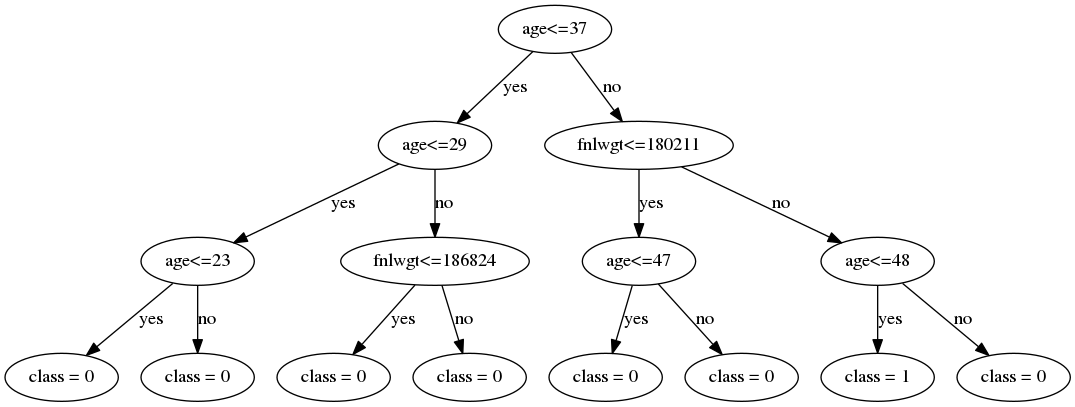

In [15]:
from IPython.display import Image
%pylab inline
open('tree_entropy.dot', 'w').write(cart_entropy.graph_str + '\n}')
!dot -Tpng tree_entropy.dot -o tree_entropy.png
Image(filename='tree_entropy.png')

In [16]:
cart_twoing = CART(17, 20, 'twoing')
cart_twoing.fit(X_train[:100], Y_train[:100])

Populating the interactive namespace from numpy and matplotlib


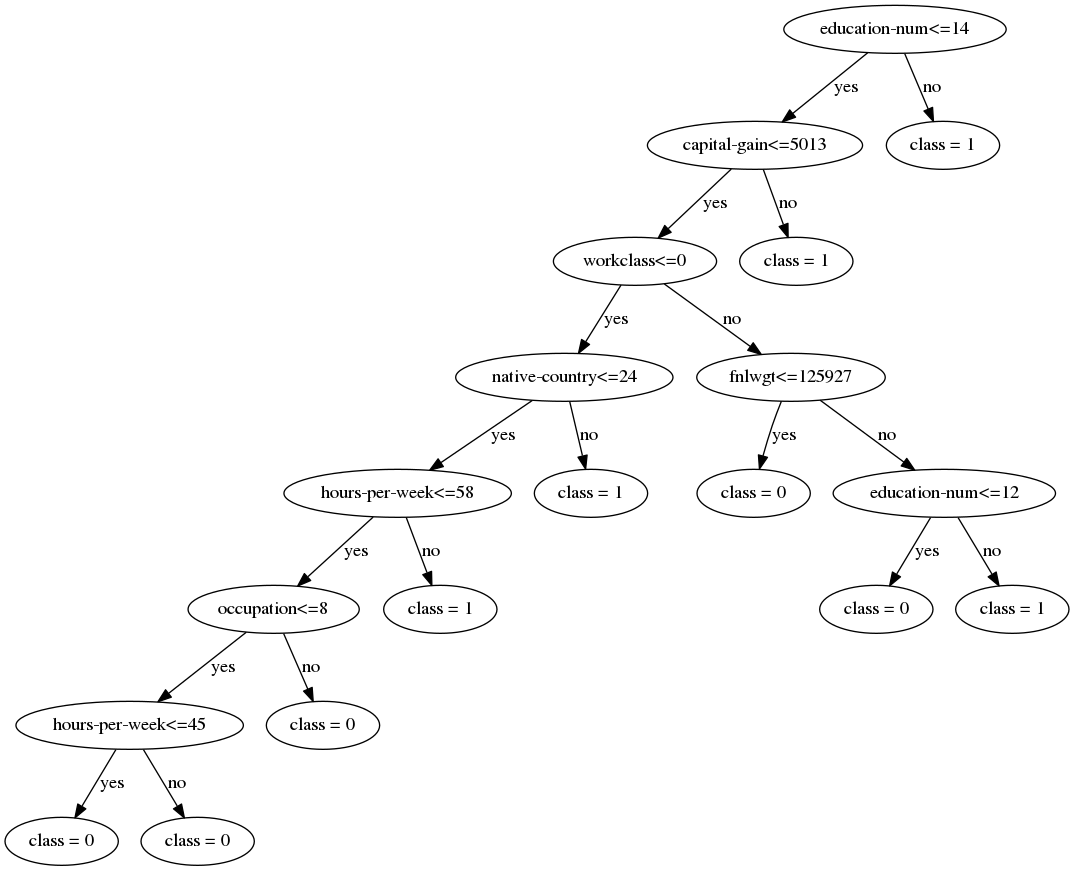

In [17]:
open('tree_twoing.dot', 'w').write(cart_twoing.graph_str + '\n}')
%pylab inline
!dot -Tpng tree_twoing.dot -o tree_twoing.png
Image(filename='tree_twoing.png')

In [68]:
#Видим, что twoing строит более глубокое и несбалансированное дерево, чем entropy

# Test evaluation

In [62]:
test = pd.read_csv('adult.val')
for col_name in nominal_columns:
    if col_name == 'label':
        continue
    print("Column: " + col_name)
    val = test[col_name]
    set_val = set(val)
    set_list = list(set_val)
    test[col_name] = map(lambda x : set_list.index(x),test[col_name])
X_test = test[test.columns[:]].values

Column: workclass
Column: relationship
Column: sex
Column: race
Column: native-country
Column: education
Column: marital-status
Column: occupation


In [63]:
assert len(X_train[0]) == len(X_test[0])

In [64]:
cart = CART(17, 20, 'twoing')
cart.fit(X_train, Y_train)

y_test = cart.predict(X_test)


In [65]:
import csv
with open('answer.csv', 'wb') as file:
    writer = csv.writer(file)
    writer.writerow(("Id","label"))
    for j in range(len(y_test)):
        writer.writerow((j, int(y_test[j])))

## Tree comparison visualisation

Automatically created module for IPython interactive environment


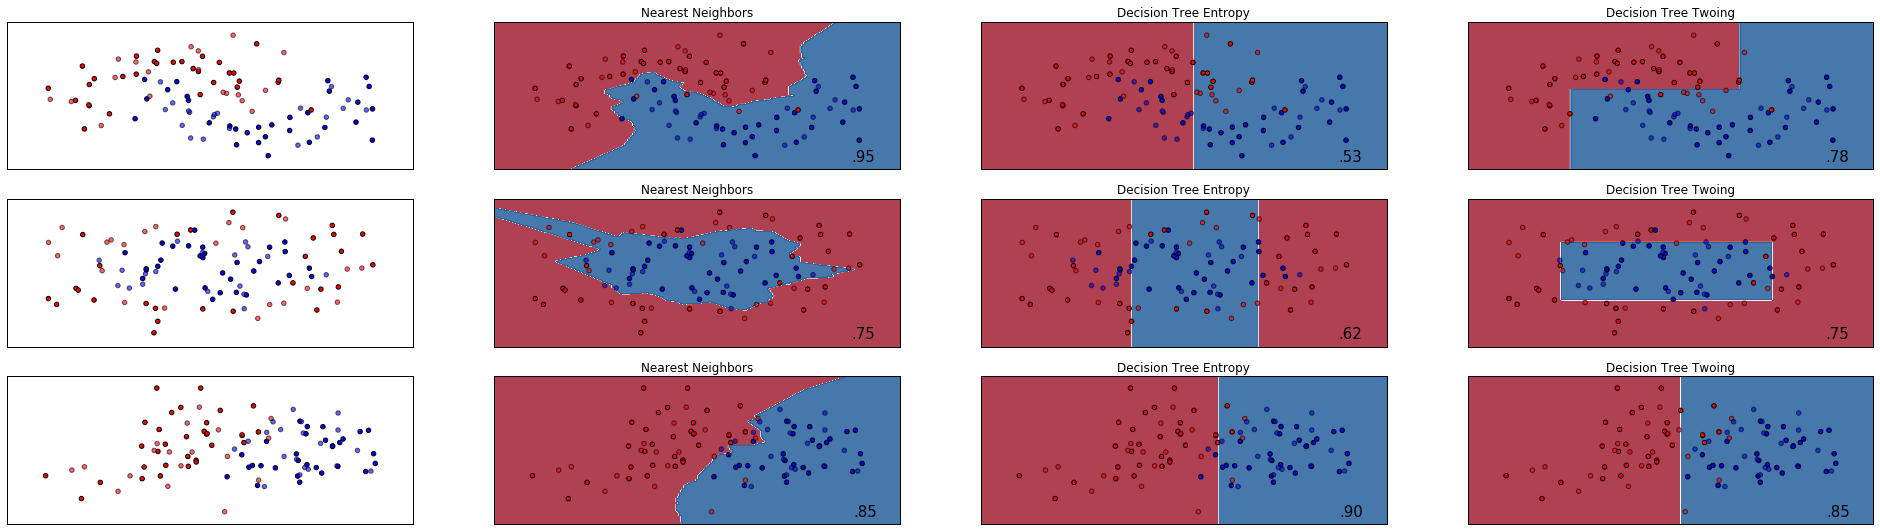

In [31]:
print(__doc__)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Decision Tree Entropy", "Decision Tree Twoing"]
classifiers = [
    KNeighborsClassifier(3), 
    CART(17, 20, 'entropy'),
    CART(17, 20, 'twoing')
    ]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds in datasets:
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        #print("X_train", X_train)
        #print("y_train", y_train)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, m_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
        # and testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

figure.subplots_adjust(left=.02, right=.98)
plt.show()

## Tree bagging
The training algorithm for random forests applies the general technique of bootstrap aggregating, or bagging, to tree learners. Given a training set $X=x_1,...,x_n$ with responses $Y = y_1, ..., y_n$, bagging repeatedly ($ B $ times) selects a random sample with replacement of the training set and fits trees to these samples.
After training, predictions for unseen samples $ x' $ can be made by averaging the predictions from all the individual regression trees on $x'$:

$$ \hat{f} = \frac{1}{B} \sum_{b=1}^B \hat{f}_b (x') $$

or by taking the majority vote in the case of decision trees.

This bootstrapping procedure leads to better model performance because it decreases the variance of the model, without increasing the bias. This means that while the predictions of a single tree are highly sensitive to noise in its training set, the average of many trees is not, as long as the trees are not correlated. Simply training many trees on a single training set would give strongly correlated trees (or even the same tree many times, if the training algorithm is deterministic); bootstrap sampling is a way of de-correlating the trees by showing them different training sets.

In [60]:
def bagging(X, y, size):
    #Implement random sampling here
    ch = np.random.choice(len(X), size)
    sample_X, sample_y = X[ch], y[ch]
    return sample_X, sample_y

In [61]:
coeff = 0.7
class Forest(sklearn.base.BaseEstimator, sklearn.base.ClassifierMixin):
    def __init__(self, num_trees):
        self.num_trees = num_trees
    
    def fit(self, X_train, y_train):
        self.trees = []
        for j in range(self.num_trees):
            (partx, party) = bagging(X_train, y_train, len(X_train) * coeff)
            new_tree = CART(17, 20, 'twoing')
            new_tree.fit(partx, party)
            self.trees.append(new_tree)
        return self
    
    def predict(self, X_test):
        print(len(X_test))
        y_pred = numpy.zeros(X_test.shape[0])
        for j in range(self.num_trees):
            y_pred += self.trees[j].predict(X_test)
        return np.around(y_pred / self.num_trees)

In [69]:
#Понятно, что ансамбль даст нам больший скор, в силу того, что хоть каждое конкретное дерево и переобучается,
#все вместе они дают хороший усредненный результат
TR = len(X_train) * 0.9
forest = Forest(10)
forest = forest.fit(X_train[:TR], Y_train[:TR])
N = 10000
y_pred = forest.predict(X_train[TR:])
wrong = np.sum(np.abs(y_pred - Y_train[TR:]))
print(1.0 - wrong * 1.0 / len(X_train[TR:]))

SyntaxError: invalid syntax (<ipython-input-69-a293dbfeffb4>, line 9)